# Tutorial

In this document, we'll show how to use this package, and compare the results to a frequentist, ad-hoc method of estimating the diffusion coefficient and its uncertainty.

In [1]:
%matplotlib inline

import Bayesian_Particle_Tracking
from Bayesian_Particle_Tracking import model
from Bayesian_Particle_Tracking.model import log_likelihood, log_posterior, log_prior, diffusion
from Bayesian_Particle_Tracking import io
from Bayesian_Particle_Tracking.prior import JeffreysPrior, UniformPrior
from Bayesian_Particle_Tracking.printable import Printable
from Bayesian_Particle_Tracking import generate_data
from Bayesian_Particle_Tracking.generate_data import data_generation, generator
import emcee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

/Users/alanzhou/anaconda3/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


We will use generated data so that it will be convenient for evaluating the validity of our method, since we will know the diffusion coefficient. For our parameters we choose $\sigma=10^{-8}$m, $\mu=10^{-4}$Pa\*s, $a=10^{-8}$m, $\tau = 1$s, where $\sigma$ is the measurement uncertainty on the particle's position, $\mu$ is the dynamic viscosity of the medium, $a$ is the radius of the particle, and $\tau$ is the time constant. the Our starting position is at the origin. We will look at a single particle over 10000 time frames or steps.

Note that from our parameters we are yielded a value of D by Stokes-Einstein:
$$D=\frac{k_bT}{6\pi\mu a}=2.1973*10^{-10} m^2/s$$

In [2]:
#Generated the data with the following code.
#data = Bayesian_Particle_Tracking.generate_data.generator(100000,10**(-8),10**(-4),10**(-8),[0,0,0])
#np.save('compare_data', data)

home_dir = "/Users/alanzhou/Documents/Physics_201/final_project/"
data = np.load(home_dir + 'compare_data.npy')
compare_input = diffusion(data)

To evaluate the diffusion coefficient we will be using Markov Chain Monte Carlo with the emcee package.

In [ ]:
#the model has 1 parameter; we'll use 40 walkers and 500 steps
ndim = 1
nwalkers = 40
nsteps = 500

#starting_positions = [abs(10**(-10) + 1e-10*np.random.randn(ndim)) for i in range(nwalkers)]

starting_positions = emcee.utils.sample_ball(
    ([10**(-10)]),
    ([10**(-10)]),nwalkers)

# set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
                                args=[compare_input])
# run the sampler. We use iPython's %time directive to tell us 
# how long it took (in a script, you would leave out "%time")
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

Plotting our walkers:

In [ ]:
fig, (ax_D) = plt.subplots(1)
ax_D.set(ylabel='D')
for i in range(nwalkers):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_D)

This is a pretty fast burn in time. We'll cut out the first 75 steps.

In [ ]:
samples = sampler.chain[:,75:,:]
# reshape the samples into a 1D array where the column is D
traces = samples.reshape(-1, ndim).T
# create a pandas DataFrame with labels. 
parameter_samples = pd.DataFrame({'D': traces[0]})

Now let's plot the marginal pdf of D:

In [ ]:
sns.kdeplot(parameter_samples['D'])
plt.title('$D$')

In [ ]:
q = parameter_samples.quantile([0.16,0.50,0.84], axis=0)

print("D = {:.3e} + {:.3e} - {:.3e}".format(q['D'][0.50], 
                                            q['D'][0.84]-q['D'][0.50],
                                            q['D'][0.50]-q['D'][0.16]))

This is very close to what we expect, and the true value of D is contained within our 68% credibility interval.

## Ad Hoc Method

This method is taken from Jerome Fung's 2013 doctoral dissertation at Harvard University, _Measuring the 3D Dynamics of Multiple Colloidal Particles_. The method, described as a "Flyvbjerg-Peterson (FB) algorithm" is described as follows:

1. Begin with correlated data (i.e., a set of squared displacements) $x_i$
2. Block-decorrelate the data (with Flybjerg-Peterson block-decorrelation). At each block decorrelation step, calculate var($x'_i$)/(N'-1)
3. To find the leftmost fixed-point region (smallest number of decorrelation setps), check if the variance estimate after $j$ transformations lies within the 1-sigma error bars of the variance estimate after j+1 transformations. The leftmost point to be considered fixed is the first point satisfying this criterior.
4. Repeat Step 3 from the right to find the rightmost edge of the fixed point region.
5. Compute a weighted average of all the var($x'_i$)/(N'-1) in the fixed-point region, where the weights by the 1-sigma error bars.

First we define our squared displacement function.

We'll also define a function to calculate MSD for illustrative purposes

In [ ]:
def sq_displacement(data):
    data_length = len(data)
    point_before = data[:len(data)-1]
    x_before, y_before, z_before = point_before[:,0], point_before[:,1], point_before[:,2]

    data_points = data[1:]
    x_data, y_data, z_data = data_points[:,0], data_points[:,1], data_points[:,2]
    distance = np.sqrt((x_before-x_data)**2+(y_before-y_data)**2+(z_before-z_data)**2)
    return distance**2

def MSD(data):
    return np.sum(sq_displacement(data))/len(data)

Below we see the results for distributions of MSDs obtained from 1000 simulated experiments in which N=1000 displacements are sampled (to generate this data the displacement array for a particle that took 1,000,000 steps  was split into 1000 arrays). The value of D is chosen with D = $2.19*10^{-10} m^2/s$ and $\tau = 1$s such that the true value of the MSD should be 

$$\langle\Delta x^2 \rangle = 6*D*\tau = 1.31*10^{-9}m^2$$

In [ ]:
test_data = np.split(data,1000)
msd_array = np.array(list(map(MSD,test_data)))
plt.hist(msd_array)
np.median(msd_array)
plt.ylabel('counts')
plt.xlabel('$\langle \Delta x^2 \\rangle$ (m$^2)$')

The standard error of the of sample variance goes as 1/$\sqrt{N}$, but to calculate the true standard error on the sample variance we use the FP algorithm.

# TODO:

Verify that the calculations for the variance of the mean and that uncertainty on the variance is correct.

In [ ]:
msd_array = sq_displacement(data)
new_length = len(msd_array)

output_var = []
var_uncertainty = []

for i in range(0,10):
    #length of the next array should be 2 times smalller (2^(i+1) times smaller overall)
    new_length = len(msd_array)/2
    new_array = np.zeros(new_length)
    #iterate over each element of the new array
    for i in range(0,len(new_array)):
        #Each element is given by the average of the corresponding 2 elements in the previous array
        new_array[i] = (msd_array[2*i-1]+msd_array[2*i])/2
    output_var.append(np.var(new_array)/(len(new_array)-1))
    var_uncertainty.append(np.var(new_array)/(len(new_array)-1)*np.sqrt(2/(len(new_array)-1)))
    msd_array = new_array

In [ ]:
b = np.arange(0,len(output_var))
plt.errorbar(b,output_var, yerr = var_uncertainty, fmt='o')
plt.ylabel('Output Variance of the Mean')
plt.xlabel('Nuber of Block Transformations')

We can see that from the FP method, we should take the average of points 3 through 5 to find the variance on the sample mean.

In [ ]:
print(np.sqrt(np.mean(output_var[2:7])))

We see that from the FP method we obtain a 68% confidence interval (1-sigma) of $\pm 1.8*10^{-11}$

Compare this to the 68% credibility interval by MCMC of $~ \pm 9*10^{-12}$

## CGW Method

This method is alluded to in Jerome Fung's Thesis, and is one of the primary ways of estimating the diffusion coefficient in colloid physics. The idea is to take a set of MSDs and then fit a line of the form 2D$\tau$ to the plot of MSD as a function of lag time. The relative standard error of the variance, $\sigma_{var}/var$ can be computed by:

$$\frac{\sigma_{var}}{var}=\sqrt{\frac{2}{N_{ind}-1}}$$

where $N_{ind}$ is the number of independent displacements. In the CGW method, this is given by:

$$N_{ind, CGW} = 2\frac{N-n}{n}$$

where n is the number of time steps between displacements for a trajectory of N timesteps.

# TODO: Implement CGW

## Actual Data

Now lets do some analysis on actual data. Data provided by Viva Horowitz

In [192]:
home_dir = "/Users/alanzhou/Documents/Physics_201/final_project/"
trajectory_dataframe = pd.read_pickle('/Users/alanzhou/Documents/Physics_201/final_project/160408,_e_coli_and_tracers_in_droplets_viva_pickled,_tracked_by_ZCC,_filtered_data_with_drift_subtracted_pickled.pkl')
trajectory_dataframe

,ecc,ep,frame,mass,particle,raw_mass,signal,size,x,y
frame,,,,,,,,,,
0,0.028655,0.048181,0.0,2009.999372,1.0,8886.0,28.436632,3.763694,549.336236,143.804503
0,0.062560,0.041715,0.0,2973.367011,4.0,10204.0,39.688537,3.840443,372.135563,168.389727
0,0.005515,0.051584,0.0,1650.961317,5.0,8325.0,29.254953,3.473140,516.364185,169.557935
0,0.065577,0.052604,0.0,1148.308038,6.0,8171.0,21.480909,3.540984,476.871945,171.904461
0,0.116574,0.051734,0.0,1863.929189,8.0,8302.0,25.163351,3.784025,579.902433,175.419332
0,0.066467,0.046582,0.0,1299.288144,18.0,9178.0,24.754191,3.459394,362.085964,252.677716
0,0.084272,0.042600,0.0,2429.183974,22.0,10000.0,33.755715,3.771988,388.877641,279.323083
0,0.121778,0.062479,0.0,965.208859,28.0,6940.0,15.548087,3.631558,701.583660,330.457355
0,0.088159,0.076062,0.0,1148.512619,29.0,5769.0,18.821368,3.656716,276.993789,330.646458


In [201]:
difference13808 = np.diff((trajectory_dataframe[trajectory_dataframe['particle'] == 13808]))
trajectory13808 = trajectory_dataframe[trajectory_dataframe['particle'] == 13808]['frame']

frame
4923    4923.0
4924    4924.0
4925    4925.0
4926    4926.0
4927    4927.0
4928    4928.0
4929    4929.0
4930    4930.0
4931    4931.0
4932    4932.0
4933    4933.0
4934    4934.0
4935    4935.0
4936    4936.0
4937    4937.0
4938    4938.0
4939    4939.0
4940    4940.0
4941    4941.0
4942    4942.0
4943    4943.0
4944    4944.0
4945    4945.0
4946    4946.0
4947    4947.0
4948    4948.0
4949    4949.0
4950    4950.0
4951    4951.0
4952    4952.0
         ...  
4973    4973.0
4974    4974.0
4975    4975.0
4976    4976.0
4977    4977.0
4978    4978.0
4979    4979.0
4980    4980.0
4981    4981.0
4982    4982.0
4983    4983.0
4984    4984.0
4985    4985.0
4986    4986.0
4987    4987.0
4988    4988.0
4989    4989.0
4990    4990.0
4991    4991.0
4992    4992.0
4993    4993.0
4994    4994.0
4995    4995.0
4996    4996.0
4997    4997.0
4998    4998.0
4999    4999.0
5001    5001.0
5002    5002.0
5003    5003.0
Name: frame, dtype: float64

In [153]:
framerate = 1/11.999
magnification = 0.12690355329e-6
relevant = trajectory_dataframe[['frame', 'ep', 'particle', 'x', 'y']]
relevant

,frame,ep,particle,x,y
frame,,,,,
0,0.0,0.048181,1.0,549.336236,143.804503
0,0.0,0.041715,4.0,372.135563,168.389727
0,0.0,0.051584,5.0,516.364185,169.557935
0,0.0,0.052604,6.0,476.871945,171.904461
0,0.0,0.051734,8.0,579.902433,175.419332
0,0.0,0.046582,18.0,362.085964,252.677716
0,0.0,0.042600,22.0,388.877641,279.323083
0,0.0,0.062479,28.0,701.583660,330.457355
0,0.0,0.076062,29.0,276.993789,330.646458


In [128]:
def single_vector(dataframe, max_counts):
    lastrow = [0,0,0,0]
    single = []
    for i in range (0, max_counts):
        if dataframe[dataframe['particle'] == i].empty == False:
            frame = np.array(dataframe[dataframe['particle'] == i][['x','y', 'ep', 'frame']])
            firstrow = [frame[0,0], frame[0,1], frame[0,2], frame[0,3]]
            new_frame = frame - firstrow + lastrow 
            length = len(frame)-1
            lastrow = [new_frame[length,0], new_frame[length,1], new_frame[length,2], new_frame[length,3]]
            single += list(new_frame)
    return np.array(single)

In [181]:
particle_max = 14000
%time single = single_vector(relevant, particle_max)
single[:,0] *= magnification
single[:,1] *= magnification
single[:,2] *= magnification
single[:,3] *= framerate


CPU times: user 12.3 s, sys: 276 ms, total: 12.6 s
Wall time: 13.1 s


In [191]:
timedifference = np.diff(single[:,3])
counter = np.arange(0,len(timedifference))

In [203]:
single = np.array([single[:,0],single[:,1],single[:,2]]).T
single

array([[  0.00000000e+00,   1.72289396e-07,   4.50588492e-07],
       [  0.00000000e+00,   1.49808139e-07,  -3.33949840e-08],
       [  0.00000000e+00,   7.28460034e-10,   9.26858171e-10]])

In [ ]:
single = diffusion(single)

In [144]:
len(single)

291020

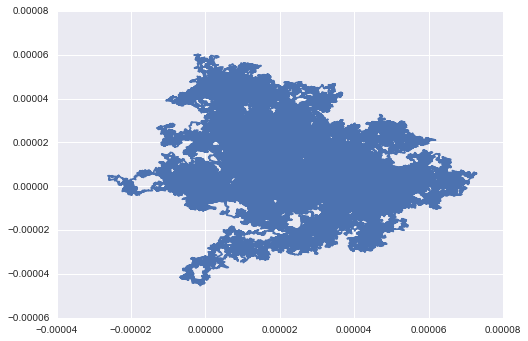

In [167]:
plt.plot(single.x, single.y)

In [178]:
single.data

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  1.72289396e-07,   1.49808139e-07,   7.28460034e-10,
          8.33402784e-02],
       [  4.50588492e-07,  -3.33949840e-08,   9.26858171e-10,
          1.66680557e-01],
       ..., 
       [  1.87484392e-05,  -8.87152356e-06,  -2.42354566e-07,
          2.53334445e+04],
       [  1.95105538e-05,  -9.41157845e-06,  -2.43176946e-07,
          2.53335278e+04],
       [  1.86990542e-05,  -8.63757815e-06,  -2.43187258e-07,
          2.53336111e+04]])

In [168]:
def max_likelihood(data, lower_bound, upper_bound, intervals):
    D = np.logspace(lower_bound, upper_bound, intervals)
    loglikelihood = np.array(list(map(lambda d: log_likelihood(d, data), D)))
    maxindex = np.argmax(loglikelihood)
    confidence = D[loglikelihood > (loglikelihood.max() - 0.5)]
    return D, D[maxindex], loglikelihood, confidence.min(), confidence.max()

In [176]:
%time D, Dbest, loglikelihood, Dmin, Dmax = max_likelihood(single, -12, -8, 10000)

CPU times: user 3min 50s, sys: 1min 8s, total: 4min 58s
Wall time: 4min 59s


In [177]:
Dbest

9.9999999999999995e-21